# Problem Statement:
Much of the AirBnB app is catered to users looking for new homes, and not much has been done to help hosts improve their housing conditions to attract more customers, as well as for them to price their house correctly.  

Hence, our group has decided to build a machine learning model to help predict appropriate price based on the important features in the owner's home using various regression tools. This will then translate to an alert to the host that tells them if their listings are over-priced or under-priced for further action.  

On top of that, we will be performing sentiment classification on the reviews given by users.  

With the sentiments in place, we would aggregate negative reviews and sieve out common complaints about the listing to the host, allowing them to have easy access to the most common problems, translating to the most effective way to improve their listing.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#importing necessary libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sb
import numpy as np
import re
import collections

# 1) EDA for Calendar Dataset

## Price Patterns over Time

In [4]:
calendar = pd.read_csv('./data/calendar.csv')
listings = pd.read_csv('./data/listings.csv')
reviews = pd.read_csv('./data/reviews.csv')

In [5]:
# we will be making use of the reviews dataframe in the sentiment classification
# will not be using it in this notebook
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

In [6]:
# drop NaN rows
calendar.dropna(inplace=True)
calendar.head()

listing_id        date available   price
0       241032  2016-01-04         t  $85.00
1       241032  2016-01-05         t  $85.00
9       241032  2016-01-13         t  $85.00
10      241032  2016-01-14         t  $85.00
14      241032  2016-01-18         t  $85.00

In [7]:
# change dtype of price to string first, for manipulation
calendar['price'] = calendar['price'].astype(str)

# we have to convert the price from str to float
def price(num):
    price = float(re.sub('[^0-9.]+','', num))
    return price

calendar['price'] = calendar['price'].apply(lambda x: price(x))
calendar.head()

listing_id        date available  price
0       241032  2016-01-04         t   85.0
1       241032  2016-01-05         t   85.0
9       241032  2016-01-13         t   85.0
10      241032  2016-01-14         t   85.0
14      241032  2016-01-18         t   85.0

In [8]:
# separating date column into day month and year
calendar['year'],calendar['month'],calendar['day'] = calendar['date'].str.split('-',2).str
calendar.head()

listing_id        date available  price  year month day
0       241032  2016-01-04         t   85.0  2016    01  04
1       241032  2016-01-05         t   85.0  2016    01  05
9       241032  2016-01-13         t   85.0  2016    01  13
10      241032  2016-01-14         t   85.0  2016    01  14
14      241032  2016-01-18         t   85.0  2016    01  18

## Trend over Month / Year

In [9]:
yearly = calendar.groupby(['year','month']).price.mean()
yearly = yearly.reset_index()
yearly['M/Y'] = yearly['month'].map(str) + "/" + yearly['year'].map(str)
yearly.head()

year month       price      M/Y
0  2016    01  121.568409  01/2016
1  2016    02  124.293927  02/2016
2  2016    03  128.644488  03/2016
3  2016    04  135.097005  04/2016
4  2016    05  139.538183  05/2016

Text(0.5, 0, 'Month/Year')

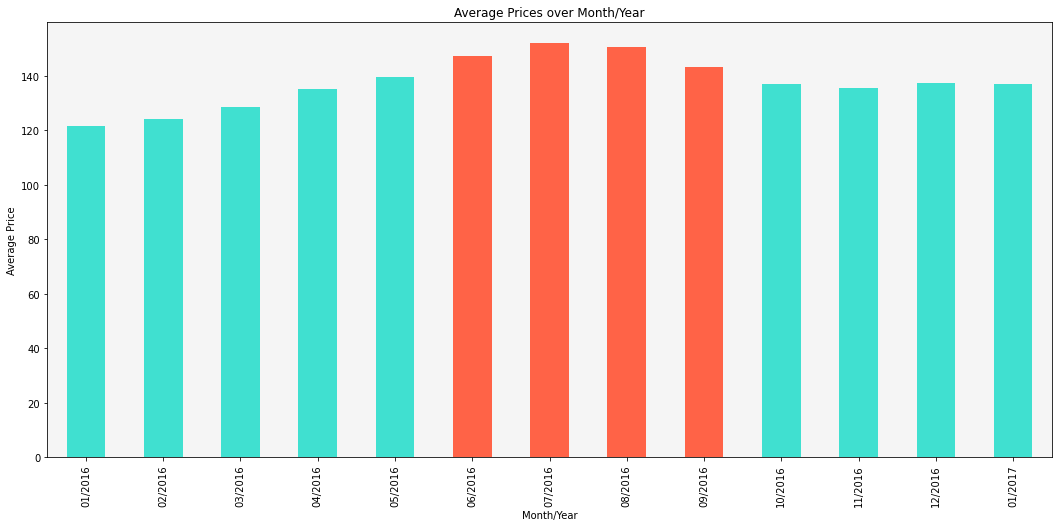

In [10]:
colours = ['turquoise' if (x < 140) else 'tomato' for x in yearly['price']]

fig = yearly.plot(kind='bar', 
           x='M/Y',
           y='price',
           color = colours, 
           figsize =(18,8), 
           title = 'Average Prices over Month/Year', 
           legend = False)
fig.set_facecolor('whitesmoke')
plt.ylabel('Average Price')
plt.xlabel('Month/Year')

- As seen from the chart, there has been a surge in prices, especially in the period from June 2016 to September 2016. This might be due to it being the summer holidays.  
<br>
- Over time, there is a general increase in prices, though it is affected by seasonal changes.

## Trend over the Week-Days

In [11]:
from datetime import date
import datetime

In [12]:
# make use of date-time in pandas to convert to day of the week
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['week_day'] = calendar['date'].dt.day_name()
calendar.head()

listing_id       date available  price  year month day   week_day
0       241032 2016-01-04         t   85.0  2016    01  04     Monday
1       241032 2016-01-05         t   85.0  2016    01  05    Tuesday
9       241032 2016-01-13         t   85.0  2016    01  13  Wednesday
10      241032 2016-01-14         t   85.0  2016    01  14   Thursday
14      241032 2016-01-18         t   85.0  2016    01  18     Monday

In [13]:
# change name of dataframe to avoid mixing up with library
df = calendar

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# make use of pandas to convert to holiday (T/F)
cal = calendar()
holidays = cal.holidays().to_pydatetime()
df['holiday'] = df['date'].isin(holidays)
df.head()

listing_id       date available  price  year month day   week_day  holiday
0       241032 2016-01-04         t   85.0  2016    01  04     Monday    False
1       241032 2016-01-05         t   85.0  2016    01  05    Tuesday    False
9       241032 2016-01-13         t   85.0  2016    01  13  Wednesday    False
10      241032 2016-01-14         t   85.0  2016    01  14   Thursday    False
14      241032 2016-01-18         t   85.0  2016    01  18     Monday     True

In [14]:
daily = df.groupby(['week_day']).price.mean()
count = df.groupby(['week_day'])['listing_id'].count()

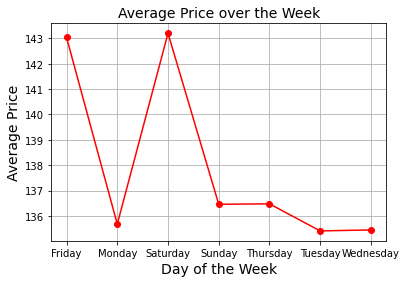

In [15]:
# plot price over week
plt.plot(daily, color='red', marker='o')
plt.grid()
plt.title('Average Price over the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Average Price', fontsize=14)

plt.show()

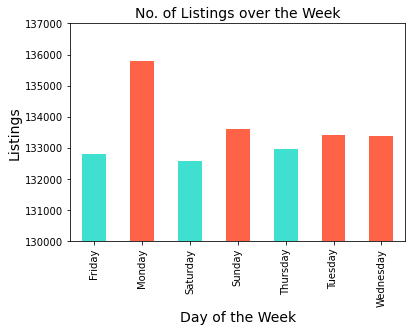

In [16]:
# plot count over week
colours = ['turquoise' if (x < 133000) else 'tomato' for x in count]
count.plot.bar(color=colours)
plt.title('No. of Listings over the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Listings', fontsize=14)
plt.ylim(130000, 137000)

plt.show()

- As seen from the price chart, Fridays and Saturdays have significantly higher prices than other days of the week, and it is understandable as these are the days with no work the next day, thus more people might be renting AirBnBs. 


- As seen from the listings chart, there are more listings on Mondays, Sundays, Tuesdays and Wednesdays, with a significant huge amount on Monday. This might be due to the fact that most AirBnB owners are not home on these days due to work.

## Trend over Holidays

In [17]:
holiday = df.groupby(['holiday']).price.mean()
count = df.groupby(['holiday'])['listing_id'].count()

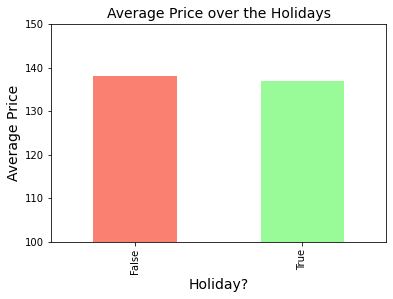

In [18]:
# plot price over holidays
holiday.plot.bar(color=['salmon','palegreen'])
plt.title('Average Price over the Holidays', fontsize=14)
plt.xlabel('Holiday?', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.ylim(100, 150)

plt.show()

- Surprisingly, whether a day is a holiday or not, it does not really affect the price of AirBnB.

# 2) EDA + Data Preparation for Listings Dataset
- We will also be performing cleaning in this section, with the help of EDA to tell if a feature is useful for predicting prices. The resulting dataframe will be prepared and used in the next notebook for machine learning.


- This will be the primary dataset used for our regression problem to identify appropriate prices for the owners. The reviews dataset will be utilized in another notebook for sentiment classification.

In [19]:
df = listings
df.head(3)

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  

[3 rows x 92 columns]

In [20]:
df.shape

(3818, 92)

In [21]:
df.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

## 2.1 Explore Price by Area

- Using latitude and longitude of each Airbnb to determine the average prices of Airbnbs located in each district

In [22]:
listings.price = listings.price.apply(lambda y: int(float(y.strip('$').replace(',',''))) )
col = ['latitude','longitude','price', 'neighbourhood']
map_df = listings[col]

In [23]:
map_df.dtypes

latitude         float64
longitude        float64
price              int64
neighbourhood     object
dtype: object

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

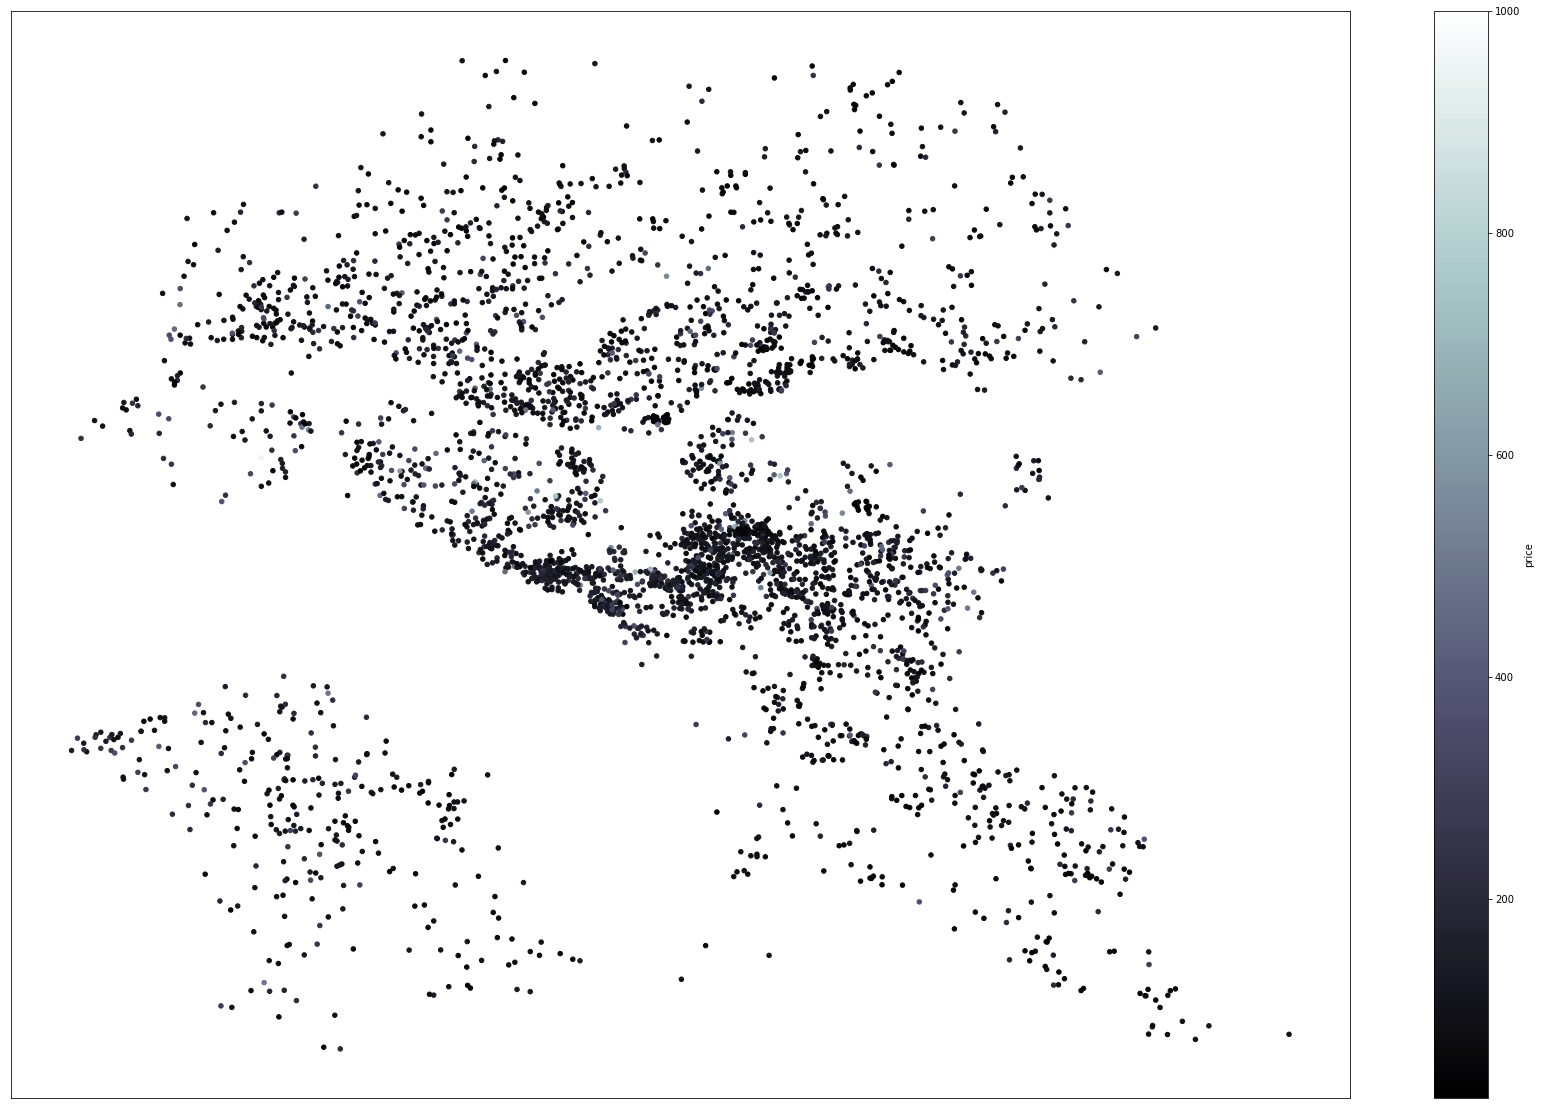

In [24]:
fig = plt.figure(figsize = (30,20))
ax = fig.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor("white")
map_df.plot.scatter('longitude', 'latitude', ax=ax, c ='price', colormap='bone')

In [25]:
import geopandas as gpd
shapefile = './Micro_Community_Policing_Plans/Micro_Community_Policing_Plans.shp'
street_map = gpd.read_file(shapefile)
street_map.head()

OBJECTID       NEIGHBORHO PRECINCT    SHAPE_Leng    SHAPE_Area  \
0       321  ALASKA JUNCTION       SW  32874.723206  3.794746e+07   
1       322             ALKI       SW  55869.551220  5.775714e+07   
2       323    BALLARD NORTH        N  49759.671684  1.249340e+08   
3       324    BALLARD SOUTH        N  38678.590263  5.886391e+07   
4       325         BELLTOWN        W  17851.419171  1.326202e+07   

                                            geometry  
0  POLYGON ((-122.37346 47.56987, -122.37346 47.5...  
1  POLYGON ((-122.37241 47.58869, -122.37486 47.5...  
2  POLYGON ((-122.36608 47.70516, -122.36607 47.7...  
3  POLYGON ((-122.36602 47.67599, -122.36573 47.6...  
4  POLYGON ((-122.35136 47.61859, -122.35134 47.6...

In [26]:
street_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

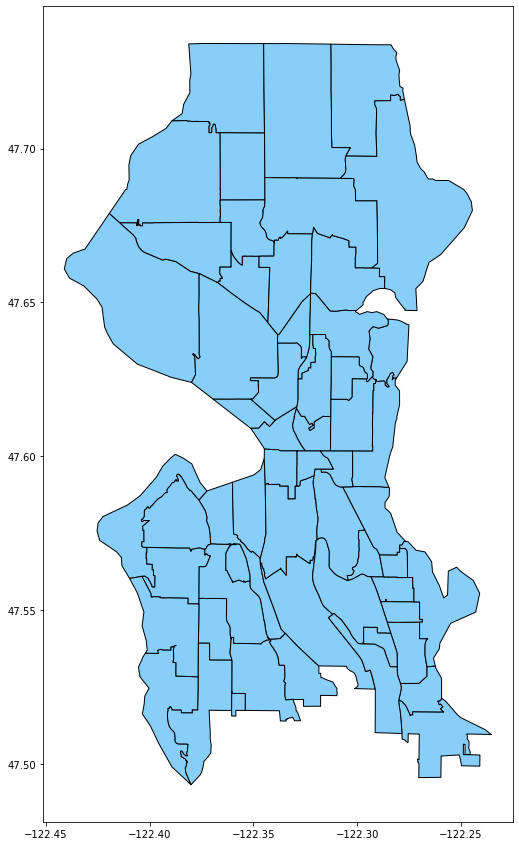

In [27]:
fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax =ax, color = 'lightskyblue', edgecolor = 'black' )

In [28]:
gdf = gpd.GeoDataFrame(map_df, geometry=gpd.points_from_xy(map_df.longitude, map_df.latitude))
gdf.head()

latitude   longitude  price neighbourhood                     geometry
0  47.636289 -122.371025     85    Queen Anne  POINT (-122.37103 47.63629)
1  47.639123 -122.365666    150    Queen Anne  POINT (-122.36567 47.63912)
2  47.629724 -122.369483    975    Queen Anne  POINT (-122.36948 47.62972)
3  47.638473 -122.369279    100    Queen Anne  POINT (-122.36928 47.63847)
4  47.632918 -122.372471    450    Queen Anne  POINT (-122.37247 47.63292)

In [29]:
avg_price = pd.pivot_table(map_df, values = 'price', index = ['neighbourhood'], aggfunc = np.mean)
avg_price.reset_index(inplace = True)
avg_price.head()

neighbourhood       price
0           Alki  196.652174
1  Arbor Heights  118.000000
2       Atlantic  116.280000
3        Ballard  123.615023
4       Belltown  166.627451

In [30]:
street_map['street'] = street_map['NEIGHBORHO'].apply(lambda x: str(x).lower())
avg_price['street'] = avg_price['neighbourhood'].apply(lambda x: str(x).lower())

In [31]:
merge_df = street_map.set_index('street').join(avg_price.set_index('street'))
merge_df.reset_index(inplace = True)

In [32]:
merge_df = pd.merge(street_map, avg_price, on='street', how='left')
merge_df.head()

OBJECTID       NEIGHBORHO PRECINCT    SHAPE_Leng    SHAPE_Area  \
0       321  ALASKA JUNCTION       SW  32874.723206  3.794746e+07   
1       322             ALKI       SW  55869.551220  5.775714e+07   
2       323    BALLARD NORTH        N  49759.671684  1.249340e+08   
3       324    BALLARD SOUTH        N  38678.590263  5.886391e+07   
4       325         BELLTOWN        W  17851.419171  1.326202e+07   

                                            geometry           street  \
0  POLYGON ((-122.37346 47.56987, -122.37346 47.5...  alaska junction   
1  POLYGON ((-122.37241 47.58869, -122.37486 47.5...             alki   
2  POLYGON ((-122.36608 47.70516, -122.36607 47.7...    ballard north   
3  POLYGON ((-122.36602 47.67599, -122.36573 47.6...    ballard south   
4  POLYGON ((-122.35136 47.61859, -122.35134 47.6...         belltown   

  neighbourhood       price  
0           NaN         NaN  
1          Alki  196.652174  
2           NaN         NaN  
3           NaN         NaN  
4      Belltown  166.627451

In [33]:
merge_df.dtypes

OBJECTID            int64
NEIGHBORHO         object
PRECINCT           object
SHAPE_Leng        float64
SHAPE_Area        float64
geometry         geometry
street             object
neighbourhood      object
price             float64
dtype: object

<AxesSubplot:xlabel='Longtitude', ylabel='Latitude'>

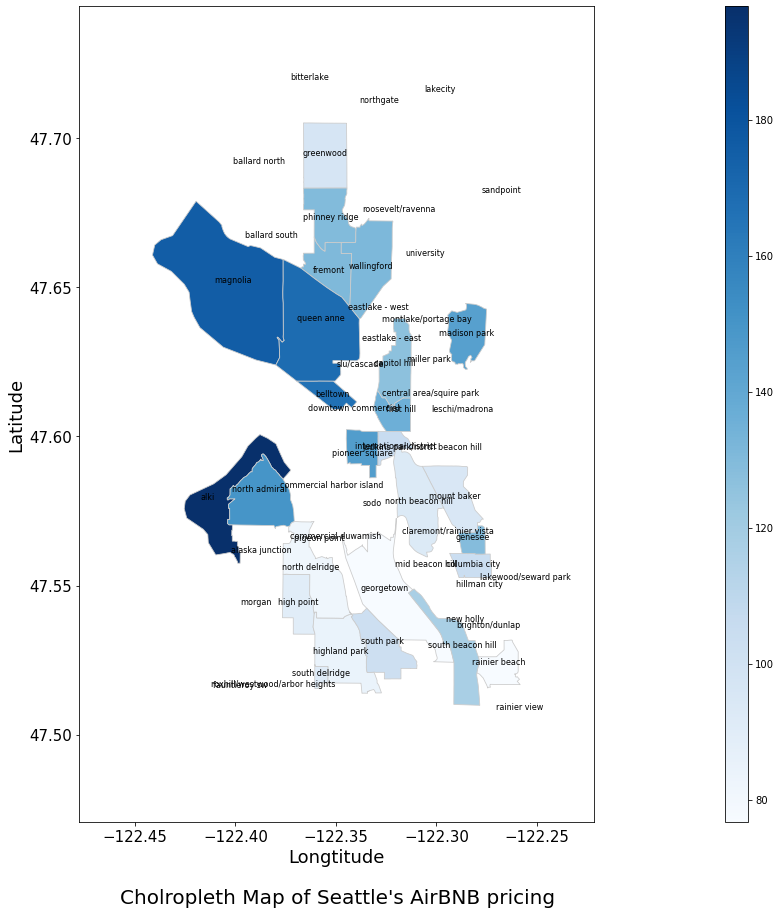

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize = (15,15) )

merge_df['coords'] = merge_df['geometry'].apply(lambda x: x.representative_point().coords[:])
merge_df['coords'] = [coords[0] for coords in merge_df['coords']]
merge_df['coords'] = merge_df['coords'].apply(pd.to_numeric)

for idx, row in merge_df.iterrows():
    plt.annotate(s = row['street'], xy = row['coords'], horizontalalignment = 'center',fontsize = 8)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "3%", pad = 0.1)

    
ax.margins(0.2, 0.2)
ax.set_xlabel('Longtitude', fontsize = 18)
ax.set_ylabel('Latitude', fontsize = 18)
ax.xaxis.set_tick_params(labelsize = 15)
ax.yaxis.set_tick_params(labelsize = 15)
txt = "Cholropleth Map of Seattle's AirBNB pricing"
plt.figtext(0.5, 0.05, txt, wrap = True, horizontalalignment = 'center', fontsize = 20)
    

merge_df.plot(column = 'price', ax = ax, legend = True, cax = cax, cmap = 'Blues', linewidth = 0.8, edgecolor = '0.8')

## 2.2 Convert Data into Numerical Form

- In this section, we will convert unstructured data types into numerical form.


- The data here are in the form of texts, lists and dictionaries, thus we will be converting them into integers for implementation into the regression algorithm.

The **transit** column contains text about how to reach the AirBnB destination.


Hence, we will sieve out the number of transits in the text to find out the number of options a user will have to reach the destination.

In [35]:
#counting the number of transport options for each house based on the available transportation listed
# this will help us to identify the number of options to go to each house
# which translates to the convenience
transit = listings['transit']
transit = transit.astype(str)

transit_types = ['bus', 'car', 'train','ferry','bike','taxi']
transit_new = []
for index, text in transit.iteritems():
  no_dup = []
  for n in transit_types:
    if n in text:
      if n not in no_dup:
        no_dup.append(n)
  count = len(no_dup)
  transit_new.append(count)

In [36]:
# new column for number of transits
df['transit_no']= transit_new
# drop original transit column
df.drop(columns=['transit'],inplace=True)
df.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... requires_license  \
0                                                NaN  ...                f   
1  Queen Anne is a wonderful, truly functional vi...  ...                f   
2  Upper Queen Anne is a charming neighborhood fu...  ...                f   
3                                                NaN  ...                f   
4  We are in the beautiful neighborhood of Queen ...  ...                f   

  license jurisdiction_names instant_bookable cancellation_policy  \
0     NaN         WASHINGTON                f            moderate   
1     NaN         WASHINGTON                f              strict   
2     NaN         WASHINGTON                f              strict   
3     NaN         WASHINGTON                f            flexible   
4     NaN         WASHINGTON                f              strict   

   require_guest_profile_picture require_guest_phone_verification  \
0                              f                                f   
1                              t                                t   
2                              f                                f   
3                              f                                f   
4                              f                                f   

  calculated_host_listings_count reviews_per_month transit_no  
0                              2              4.07          0  
1                              6              1.48          2  
2                              2              1.15          1  
3                              1               NaN          0  
4                              1              0.89          1  

[5 rows x 92 columns]

In the cells below, we will clean the **host_verifications** and **amenities** columns to sieve out the count of each column.


The **price** column will be converted from a object to a float for input into the regression algorithm later.

In [38]:
df['number_host_verifications']= df['host_verifications'].apply(lambda x: len(x.strip('][').split(','))) #counting number of verifications according to the list of amenities listed
df['number_amenities']= df['amenities'].apply(lambda y: len(y.strip('}{').split(',')) ) #counting number of amenities according to the list of amenities listed

# drop original columns
df.drop(columns=['host_verifications','amenities'], inplace=True)
df.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... jurisdiction_names  \
0                                                NaN  ...         WASHINGTON   
1  Queen Anne is a wonderful, truly functional vi...  ...         WASHINGTON   
2  Upper Queen Anne is a charming neighborhood fu...  ...         WASHINGTON   
3                                                NaN  ...         WASHINGTON   
4  We are in the beautiful neighborhood of Queen ...  ...         WASHINGTON   

  instant_bookable cancellation_policy require_guest_profile_picture  \
0                f            moderate                             f   
1                f              strict                             t   
2                f              strict                             f   
3                f            flexible                             f   
4                f              strict                             f   

  require_guest_phone_verification  calculated_host_listings_count  \
0                                f                               2   
1                                t                               6   
2                                f                               2   
3                                f                               1   
4                                f                               1   

  reviews_per_month transit_no number_host_verifications number_amenities  
0              4.07          0                         4               10  
1              1.48          2                         6               16  
2              1.15          1                         5               21  
3               NaN          0                         5               14  
4              0.89          1                         5               13  

[5 rows x 92 columns]

## 2.3 Categorical Data
- In this section, we will be performing EDA on our categorical-type columns.


- From the EDA, we will be able to deduce whether the feature helps in the prediction of prices, and we will only keep those that are useful.


- This will help us prepare the categorical variables for regression.

In [39]:
categorical_df=df[['id','property_type','room_type','neighbourhood','price']] #filtering categorical data into a new dataframe for vizualization
price = pd.DataFrame(categorical_df['price'])
room_type = pd.DataFrame(categorical_df['room_type'])
property_type = pd.DataFrame(categorical_df['property_type'])
neighbourhood = pd.DataFrame(categorical_df['neighbourhood'])

In [40]:
#inputs column name of categorical_df in string format and filters the categories that have very small counts
def df_trim(category):
    category1 = pd.DataFrame(categorical_df[category]) #define the column of interest
    category_count = pd.DataFrame(category1[category].value_counts()) #count of each unique value in the column
    value = len(category1)/len(category_count) #benchmark set for the column
    category_count = category_count[category].apply(lambda x:x if x>value else 0) #replacing those below the benchmark with 0
    category_keep = []
    
#makes a list of variables that we are keeping
    for name, count in category_count.iteritems():
        if count > 0:
            category_keep.append(name)

    for index in category1.index:
        if category1.loc[index,category] not in category_keep:
            category1.loc[index,category] = 0    
    return category1, category_keep

### Neighbourhood

In [41]:
neighbourhood, interest = df_trim('neighbourhood') # to exclude the category that has 0 in the swarmplot

Text(0.5, 1.0, 'Price vs Neighbourhood')

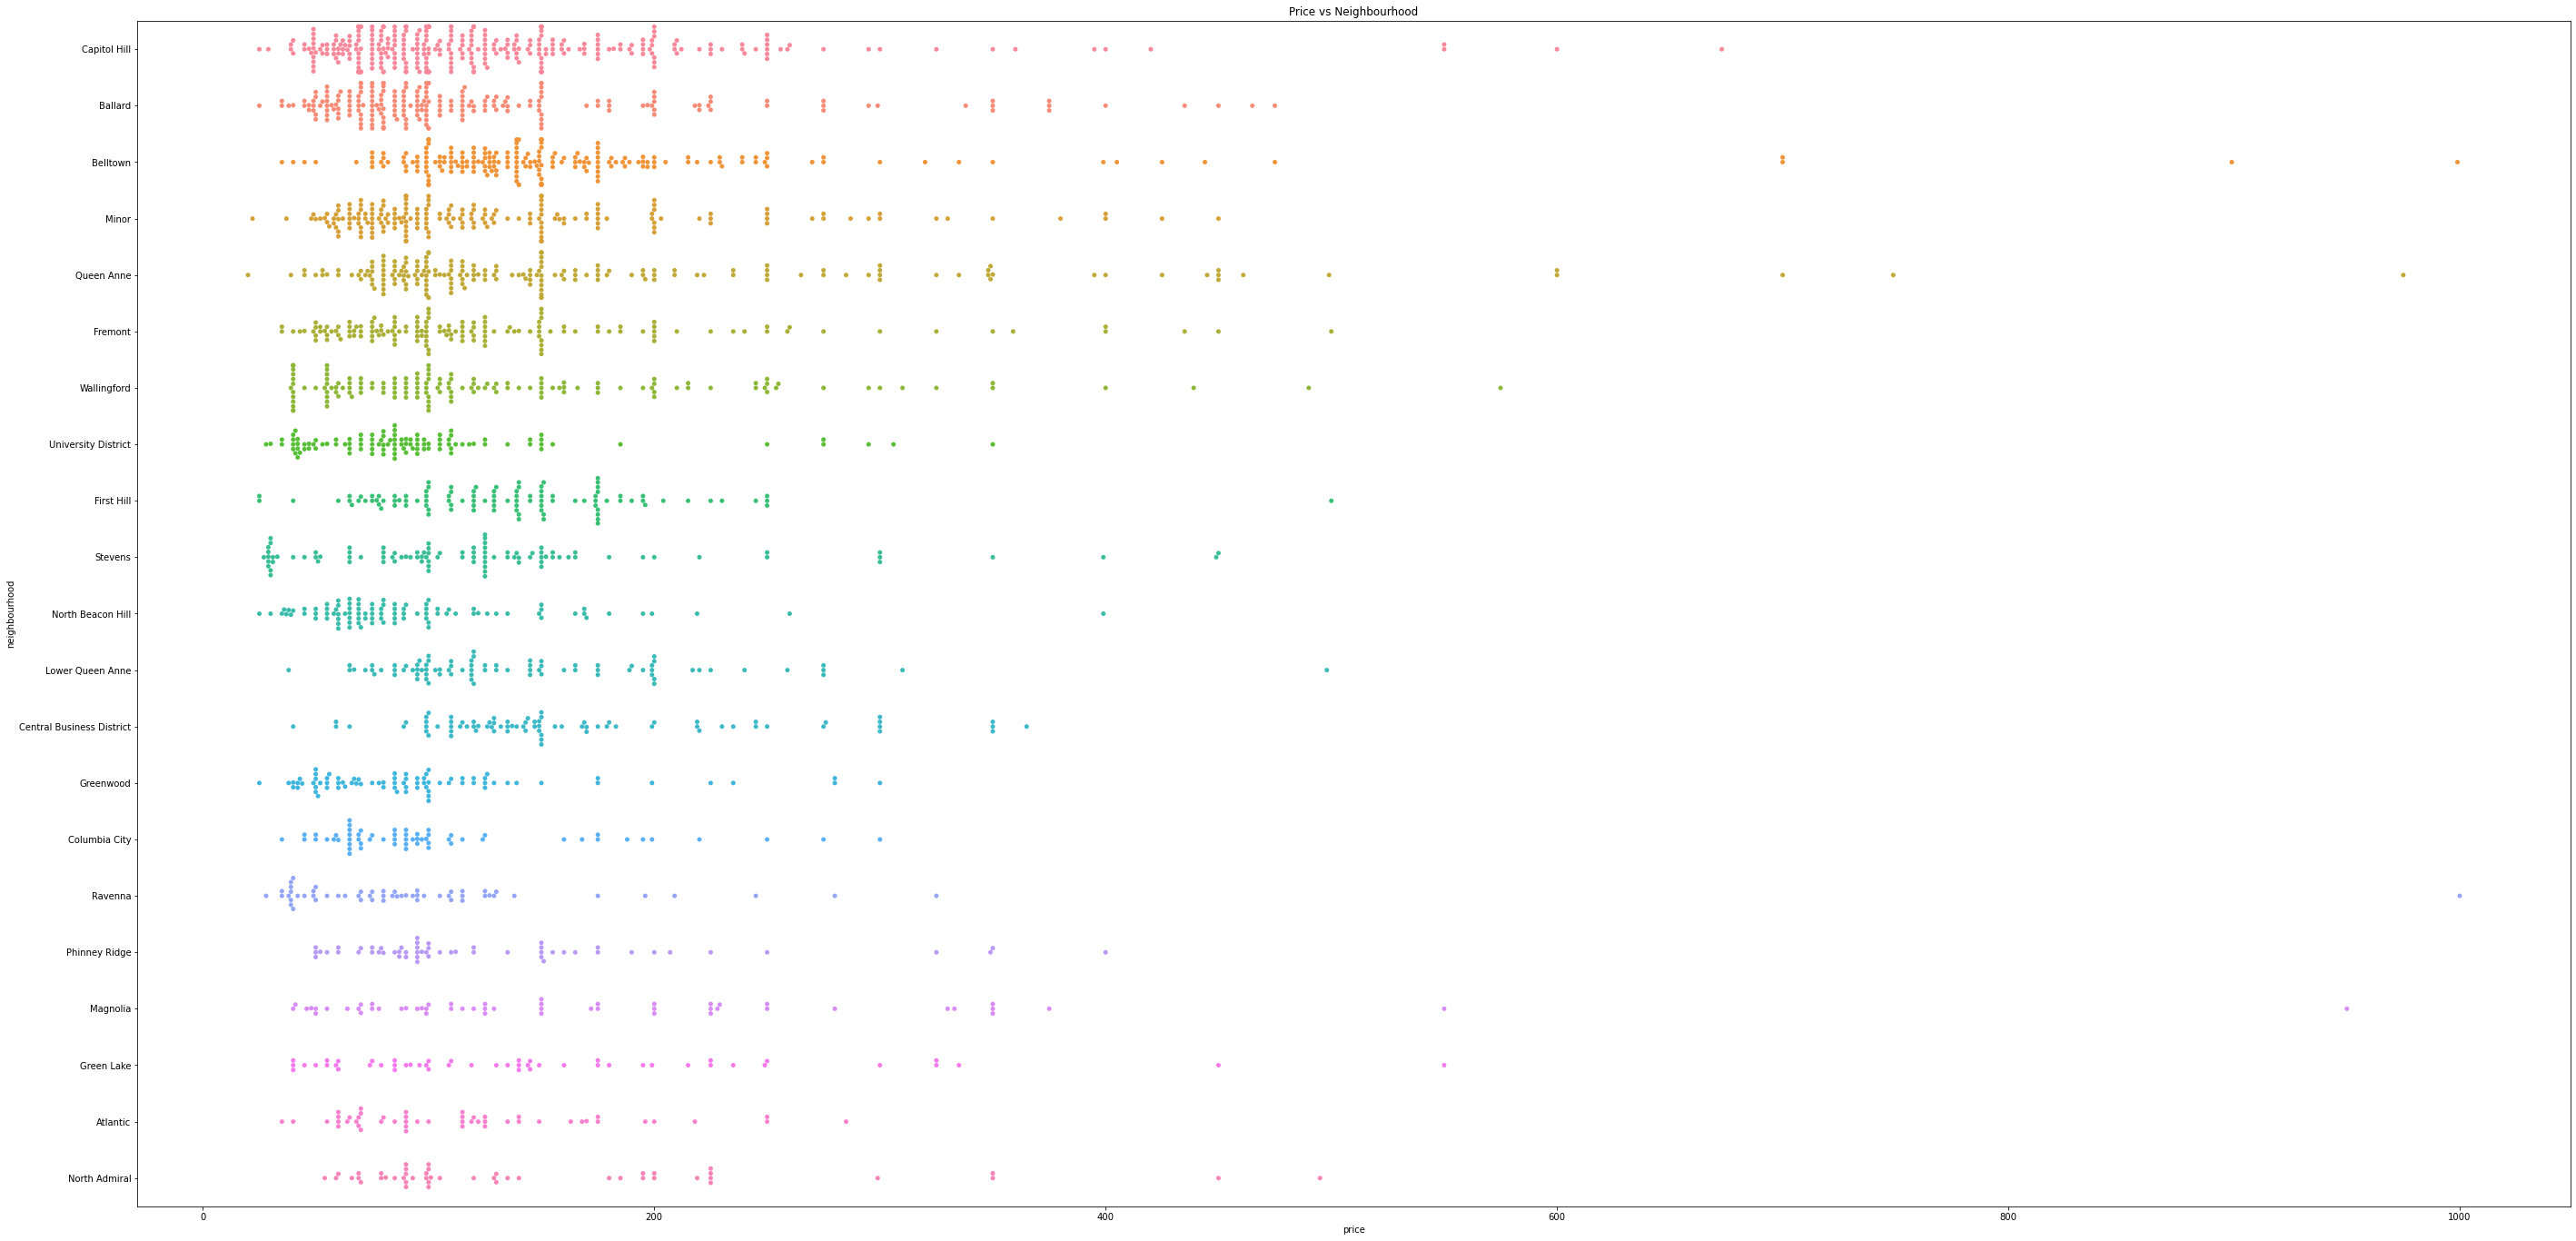

In [42]:
# Plot price against neighbourhood
jointDF = pd.concat([price, neighbourhood], axis = 1).reindex(price.index)
f = plt.figure(figsize=(48, 24))
sb.swarmplot(x = "price", y = "neighbourhood", data = jointDF, orient = "h", 
             order=interest).set_title('Price vs Neighbourhood')

- As seen from the swarmplot of price vs neighbourhood, neighbourhood does not help us distinguish prices.


- Hence, we will be removing it from our dataset.

### Room Type

<AxesSubplot:title={'center':'Room Type Distribution'}, ylabel='count'>

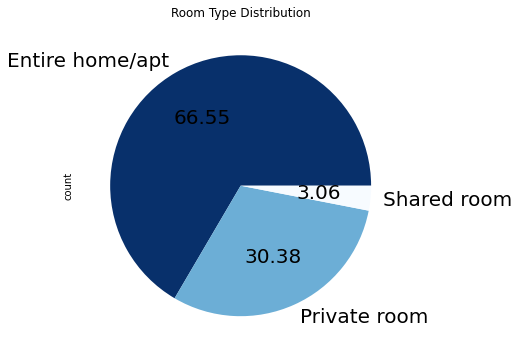

In [43]:
from collections import Counter

room = room_type
room['count'] = 1
group_room = room.groupby('room_type')['count'].sum()
group_room.plot.pie(y = 'room_type', 
                 colormap = 'Blues_r', 
                 figsize=(6,6), 
                 fontsize = 20, autopct = '%.2f',
                 legend = False,
                 title = 'Room Type Distribution')

Text(0.5, 1.0, 'Price vs Room Type')

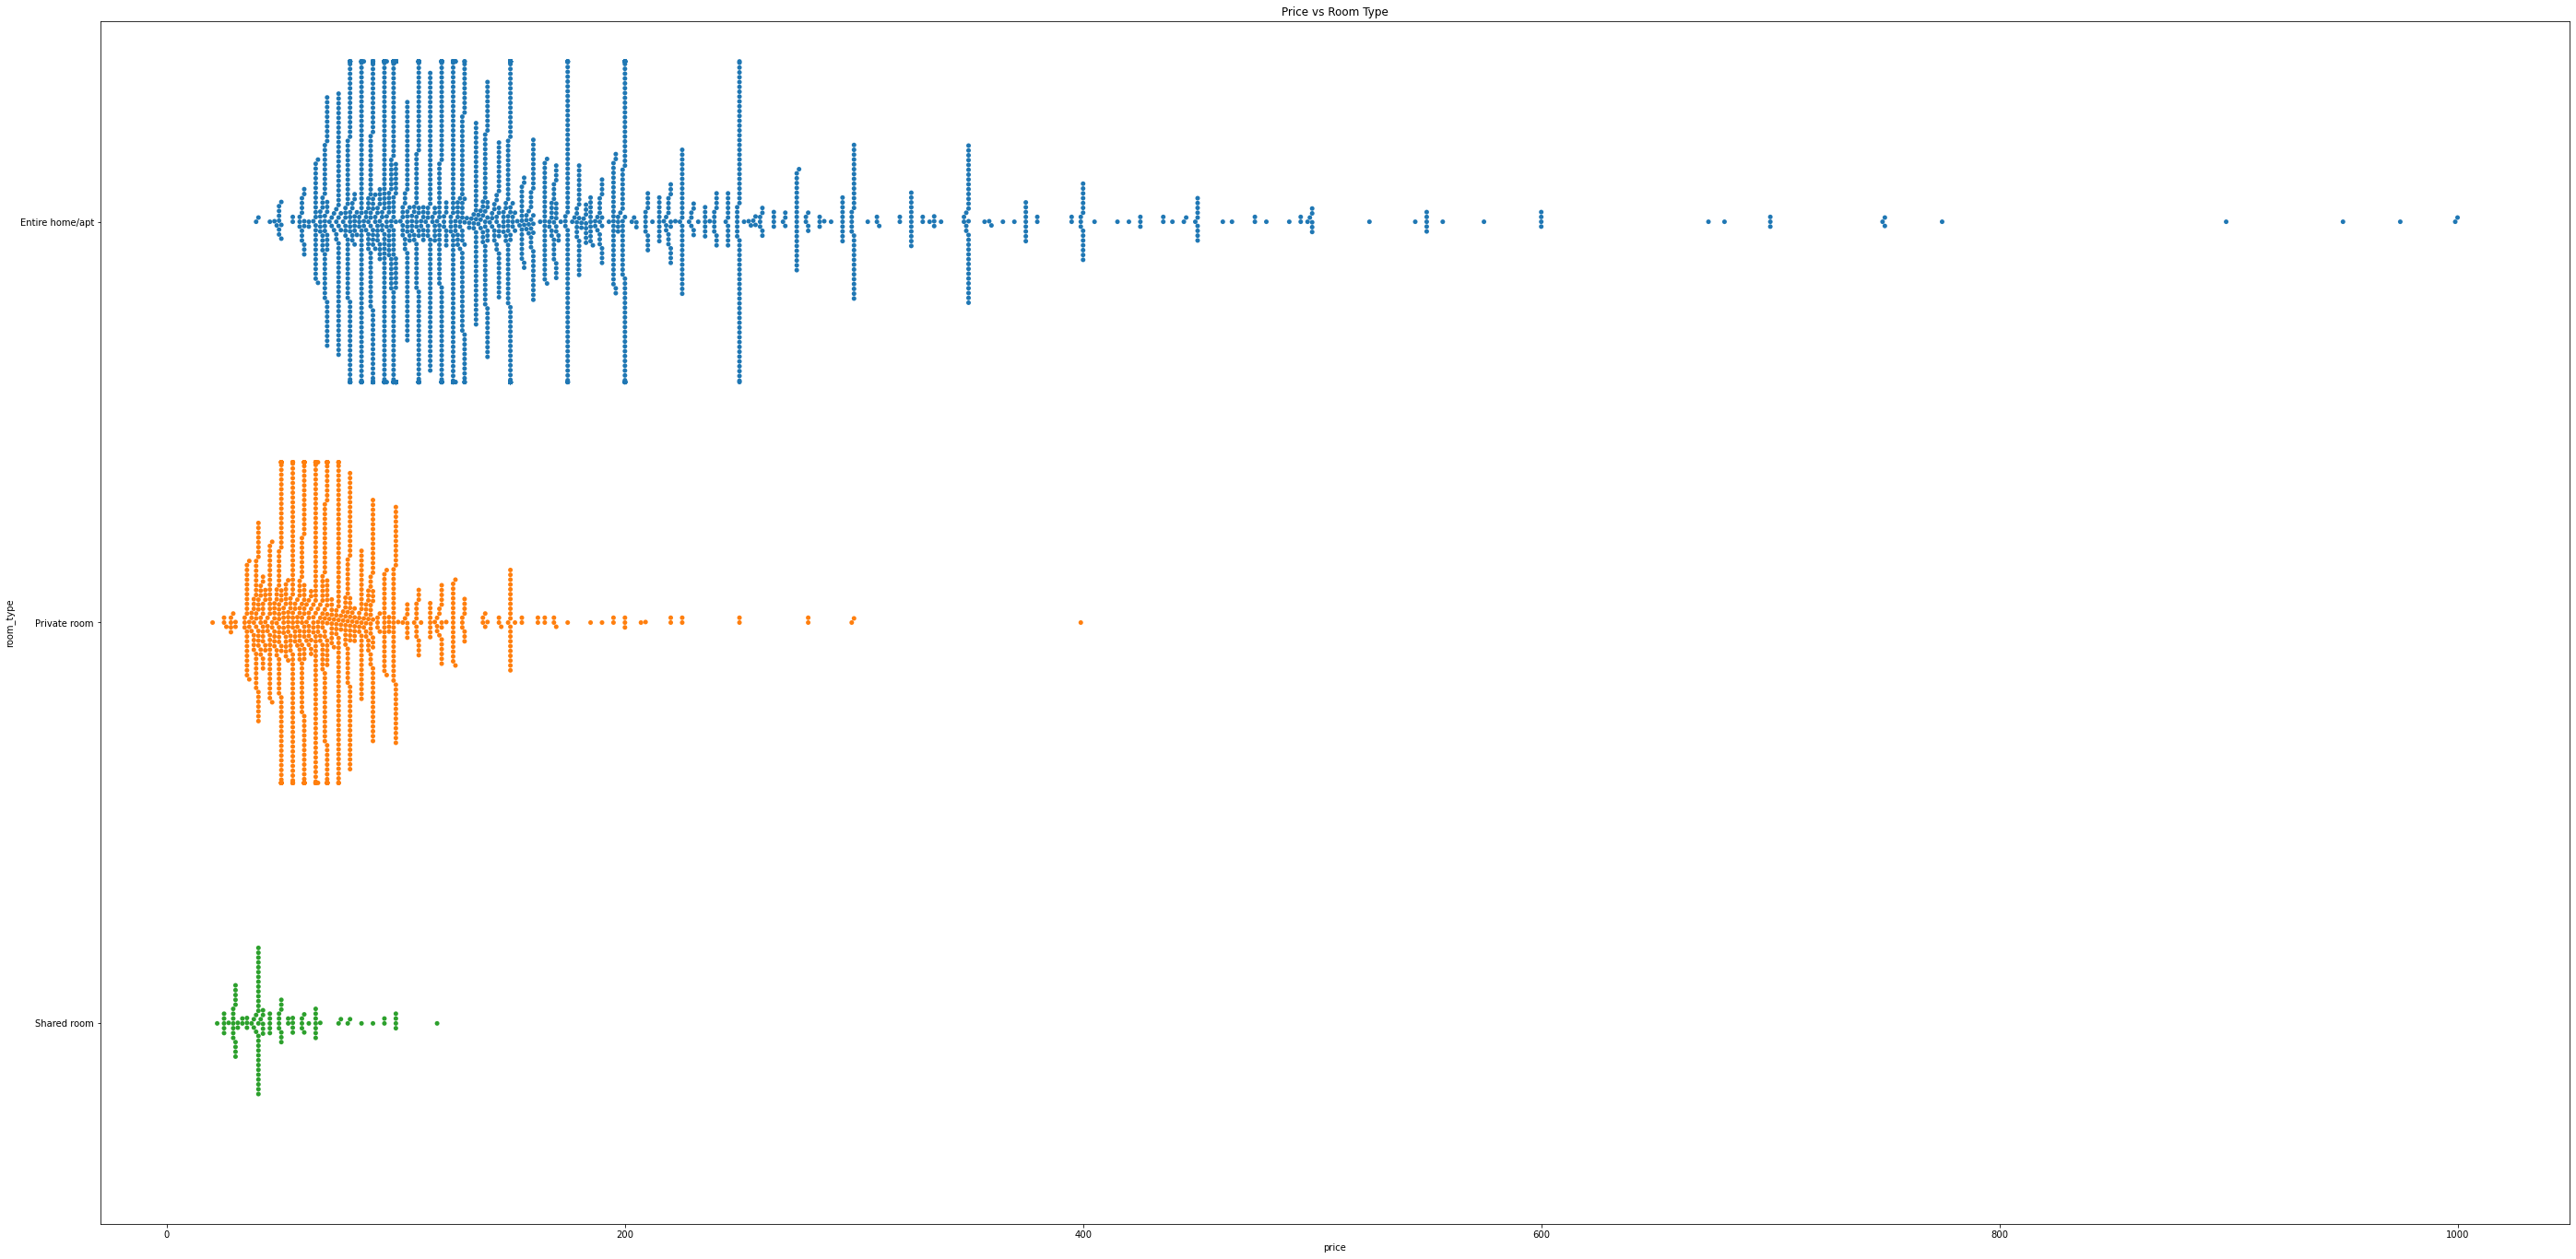

In [44]:
jointDF = pd.concat([price, room_type], axis = 1).reindex(price.index)
f = plt.figure(figsize=(48, 24))
sb.swarmplot(x = "price", y = "room_type", data = jointDF, orient = "h").set_title('Price vs Room Type')
#since the diagram is visually clear, there is no need to trim it

- From the room-type distribution, we see that majority (about 2/3) of listings on AirBnB are entire homes. A small portion (about 1/3) of them are private rooms, with shared rooms being an insignificant portion.


- From the price vs room type plot, room type does help us distinguish prices, thus we will be keeping it.

### Property Type

In [45]:
property_type, interest = df_trim('property_type') # to exclude the category that has 0 in the swarmplot

<AxesSubplot:title={'center':'Property Type Distribution'}, ylabel='count'>

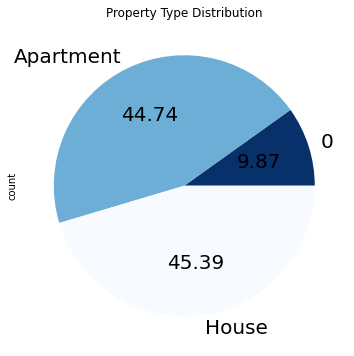

In [46]:
prop = property_type
prop['count'] = 1
group_prop = prop.groupby('property_type')['count'].sum()

group_prop.plot.pie(y = 'property_type', 
                 colormap = 'Blues_r', 
                 figsize=(6,6), 
                 fontsize = 20, autopct = '%.2f',
                 legend = False,
                 title = 'Property Type Distribution')

Text(0.5, 1.0, 'Price vs Property Type')

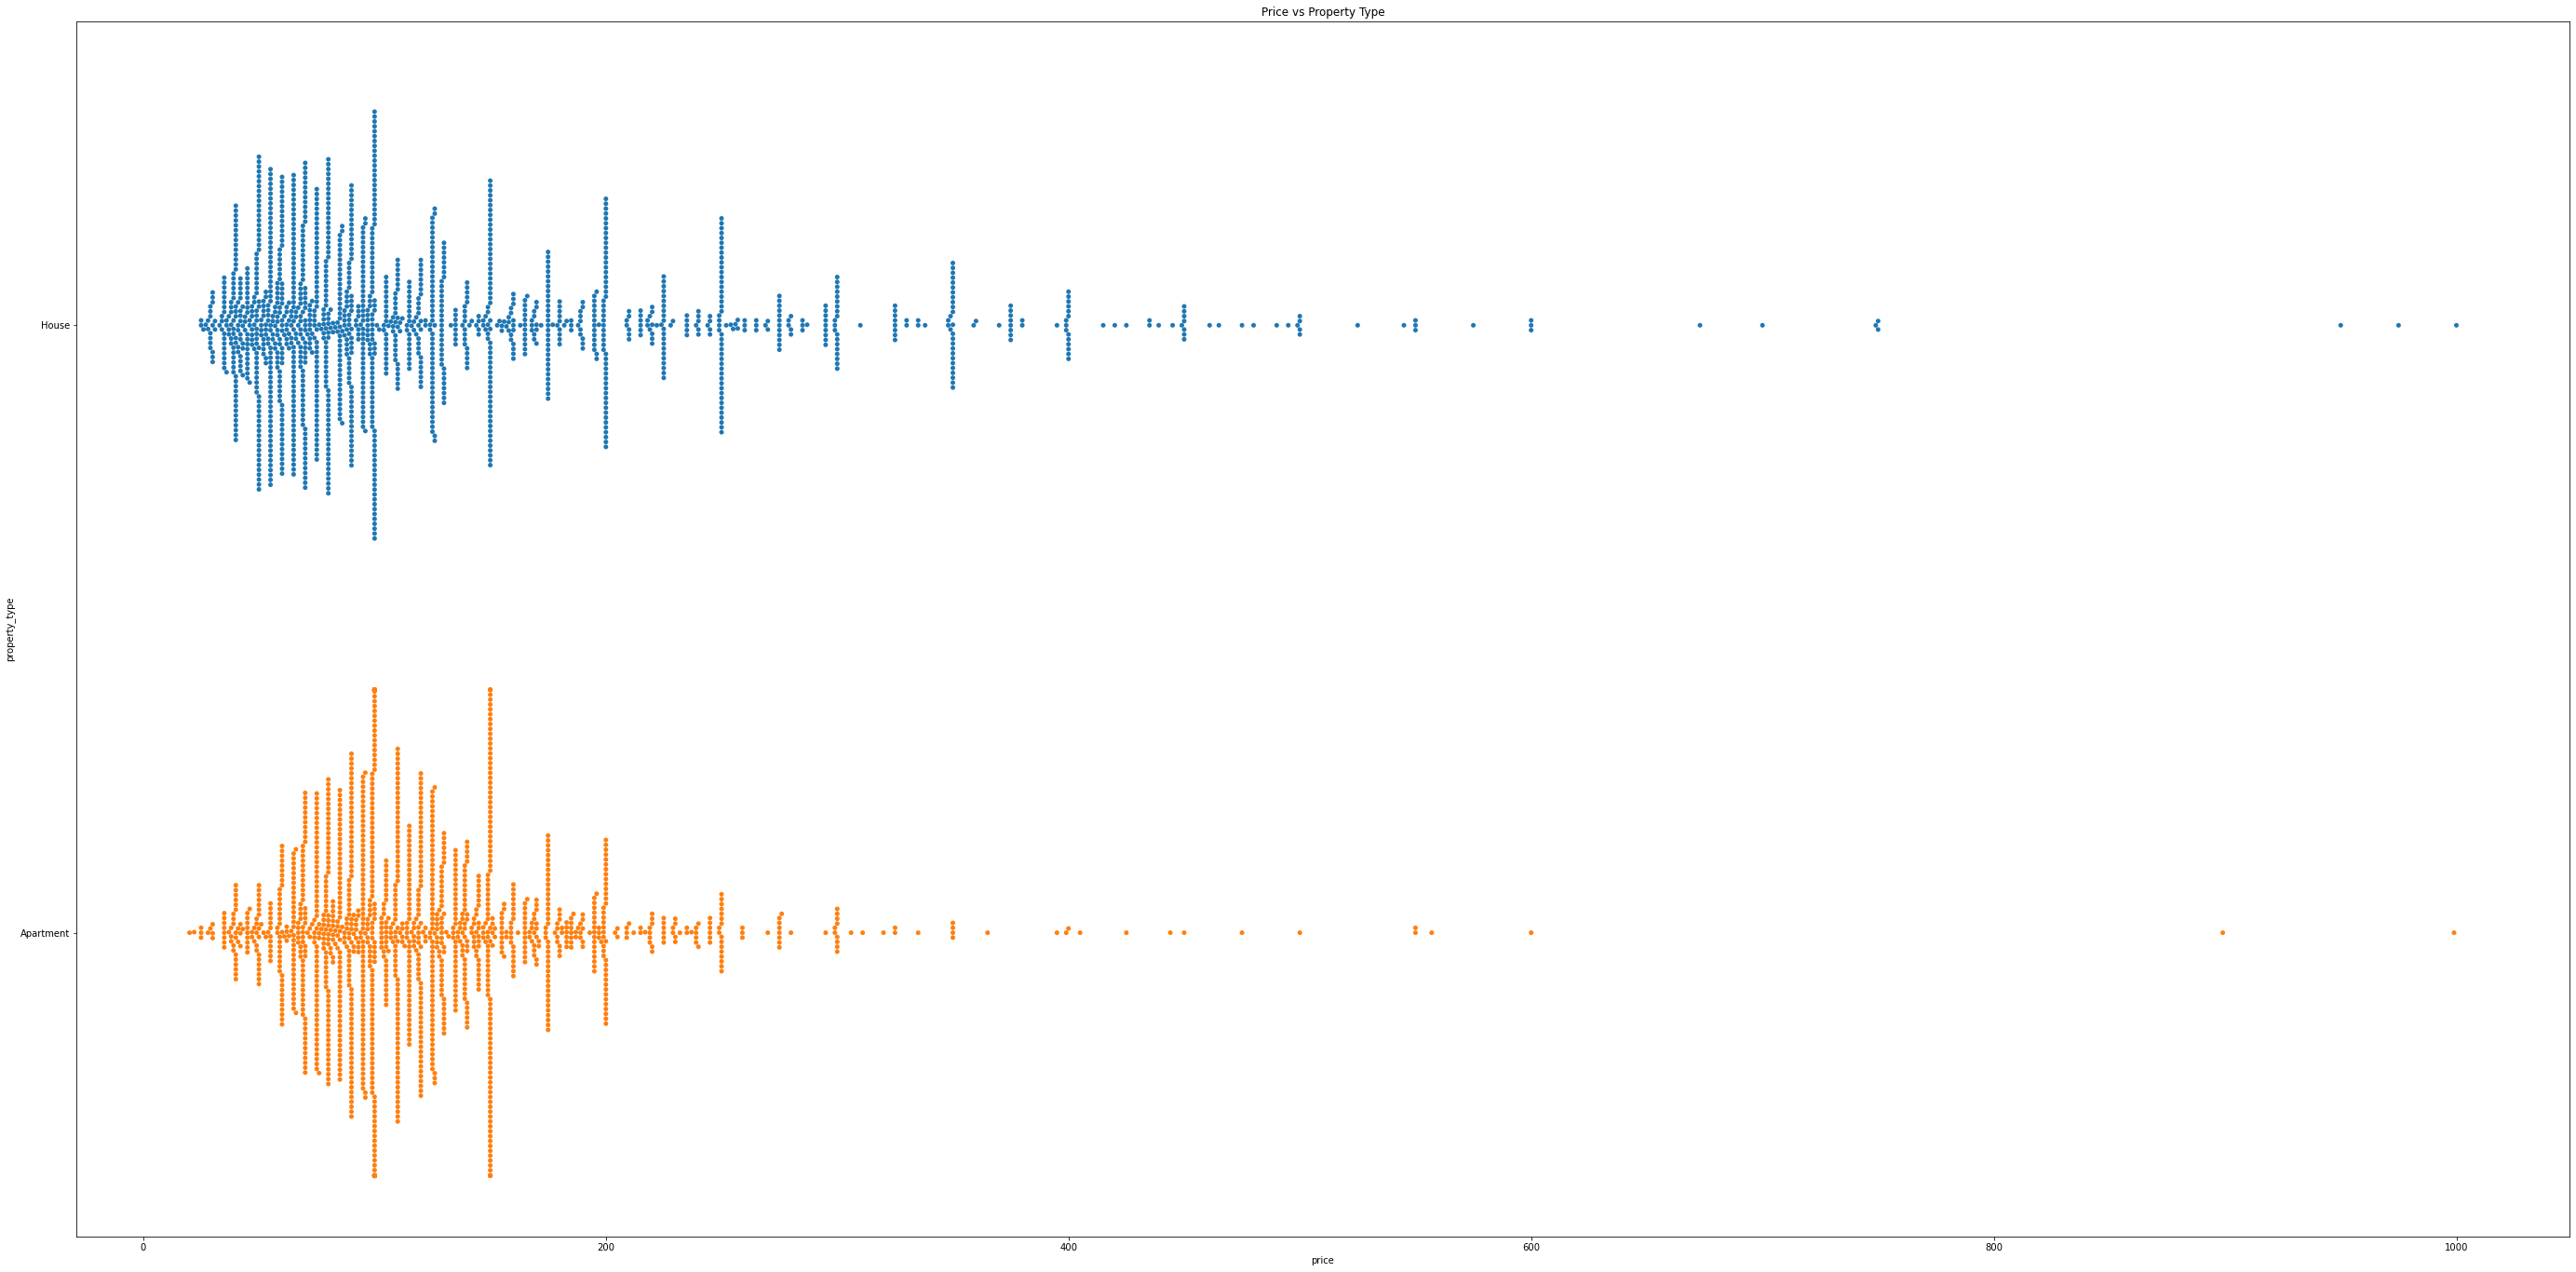

In [47]:
jointDF = pd.concat([price, property_type], axis = 1).reindex(price.index)
f = plt.figure(figsize=(48, 24))
sb.swarmplot(x = "price", y = "property_type", data = jointDF, 
             orient = "h", order = interest).set_title('Price vs Property Type')

- From the property type distribution, there is almost an equal percentage of apartment and house types in AirBnB listings, with almost 10% of the data being unlabelled.


- From the price vs property type plot, property type does not help us in predicting prices, thus we will remove it.

In [48]:
categorical_df.head() #categorical data to keep

id property_type        room_type neighbourhood  price
0   241032     Apartment  Entire home/apt    Queen Anne     85
1   953595     Apartment  Entire home/apt    Queen Anne    150
2  3308979         House  Entire home/apt    Queen Anne    975
3  7421966     Apartment  Entire home/apt    Queen Anne    100
4   278830         House  Entire home/apt    Queen Anne    450

##  2.4 Numerical Data
- In this section, we will be performing EDA on our numerical-type columns.


- From the EDA, we will be able to deduce whether the feature helps in the prediction of prices, and we will only keep those that are useful.


- This will help us prepare the numerical variables for regression.

###  2.4.1 Exploring All Numerical Data in "listings.csv"

- To avoid missing out on any key features, we will check all numerical features in the csv and check their correlation to price

- Features that have a correlation of above 0.35 will be deemed as reasonably useful and will be kept

In [49]:
df = listings

#changing price from a str to int
try:
    listings['price']= listings['price'].apply(lambda y: int(float(y.strip('$').replace(',',''))) ) 
except:
    pass

#choosing numerical data from the df
numerical_df = df.select_dtypes(include=['int64','float'])

findcorr = numerical_df.corr()
corr = findcorr.to_dict()

import plotly.express as px

X = list(corr['price'].keys())
y = list(corr['price'].values())

colors = ['Keep' if c > 0.35 else 'Positive' if c > 0 else 'Negative' for c in y]

fig = px.bar(
    x=X, y=y, color=colors,
    color_discrete_sequence=['red', 'blue', 'green'],
    labels=dict(x='Feature', y='Correlation coefficient'),
    title='Correlation (F)'
)

fig.show()

numerical_features = []
for x in findcorr['price']:
  if x > 0.35 and x < 1:
    feature = findcorr[findcorr['price']==x].index.values
    print('Coefficient=','%.3f'% x, '\t Feature: ',feature)
    numerical_features.append(feature)
    
#choosing relevant numeric features
numerical_features = [x[0] for x in numerical_features]
numerical_df = df[numerical_features]
numerical_df.head()

Coefficient= 0.652 	 Feature:  ['accommodates']
Coefficient= 0.516 	 Feature:  ['bathrooms']
Coefficient= 0.628 	 Feature:  ['bedrooms']
Coefficient= 0.590 	 Feature:  ['beds']
Coefficient= 0.532 	 Feature:  ['square_feet']
Coefficient= 0.393 	 Feature:  ['guests_included']


accommodates  bathrooms  bedrooms  beds  square_feet  guests_included
0             4        1.0       1.0   1.0          NaN                2
1             4        1.0       1.0   1.0          NaN                1
2            11        4.5       5.0   7.0          NaN               10
3             3        1.0       0.0   2.0          NaN                1
4             6        2.0       3.0   3.0          NaN                6

- As seen from the correlation plot above, many of the features in our numerical dataframe do not help us in predicting the prices due to their low correlation.


- Hence, they may add noise to our data, and we will only be keeping the columns that are highlighted in green in the plot above.

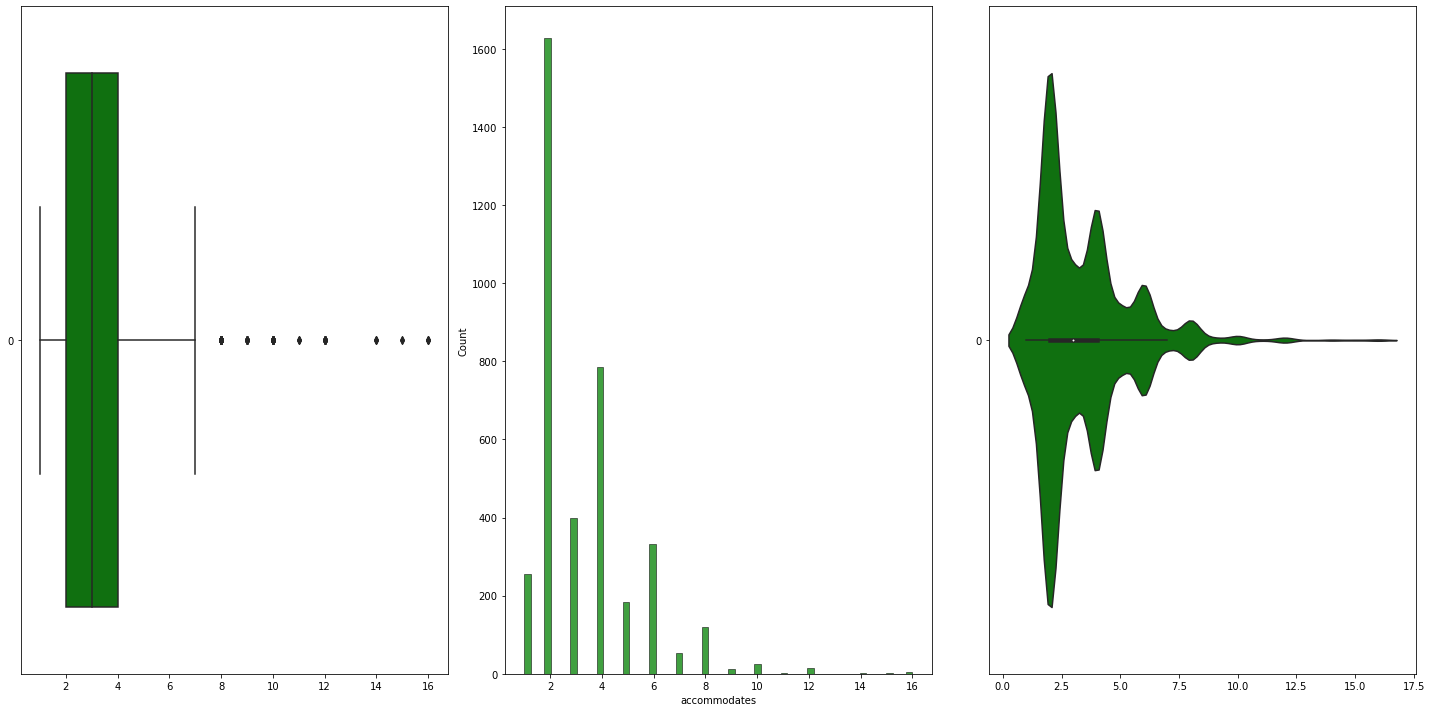

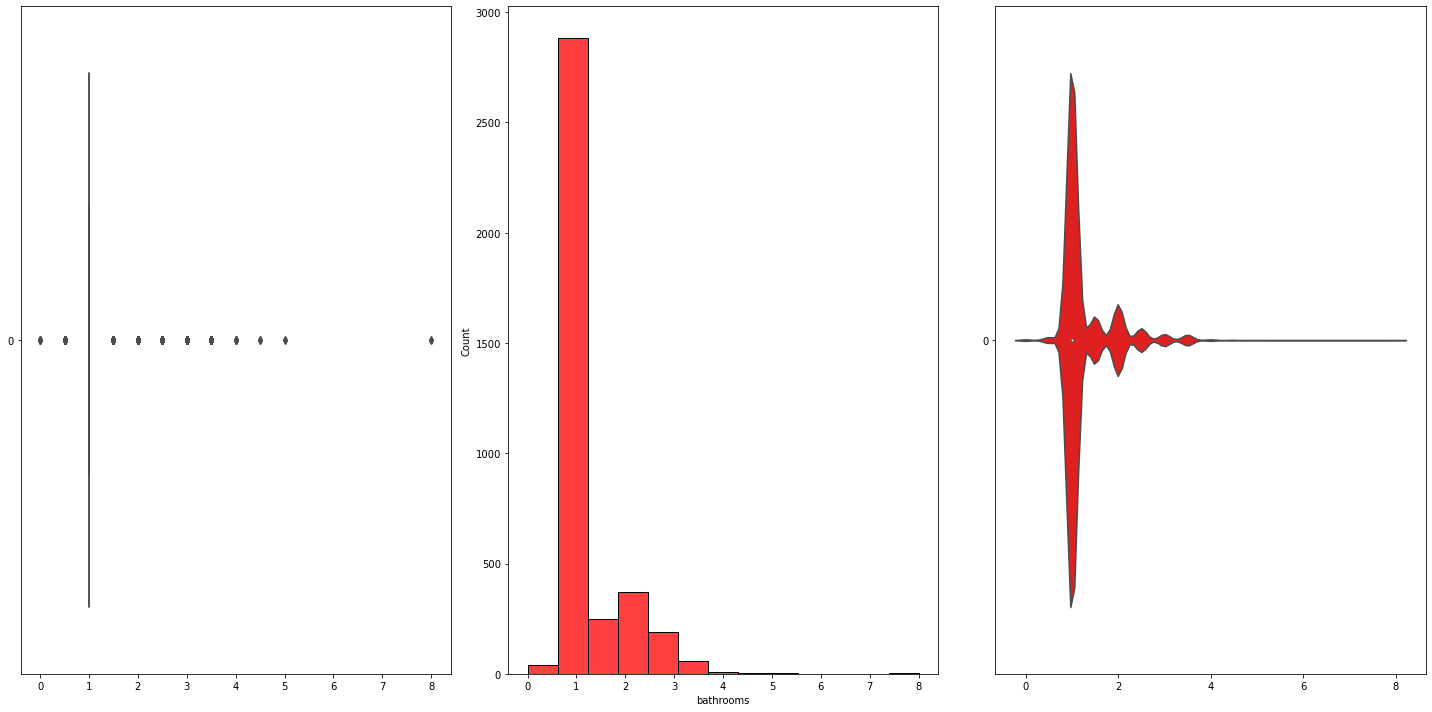

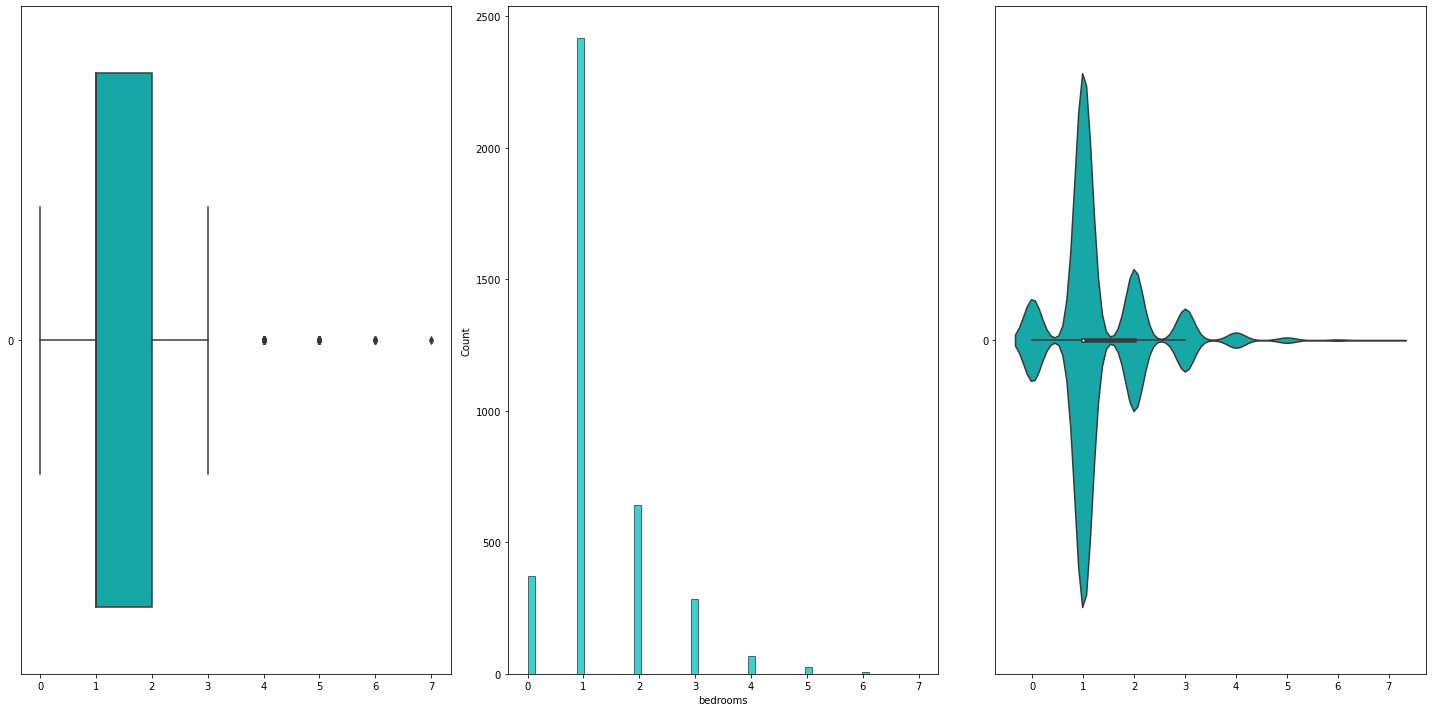

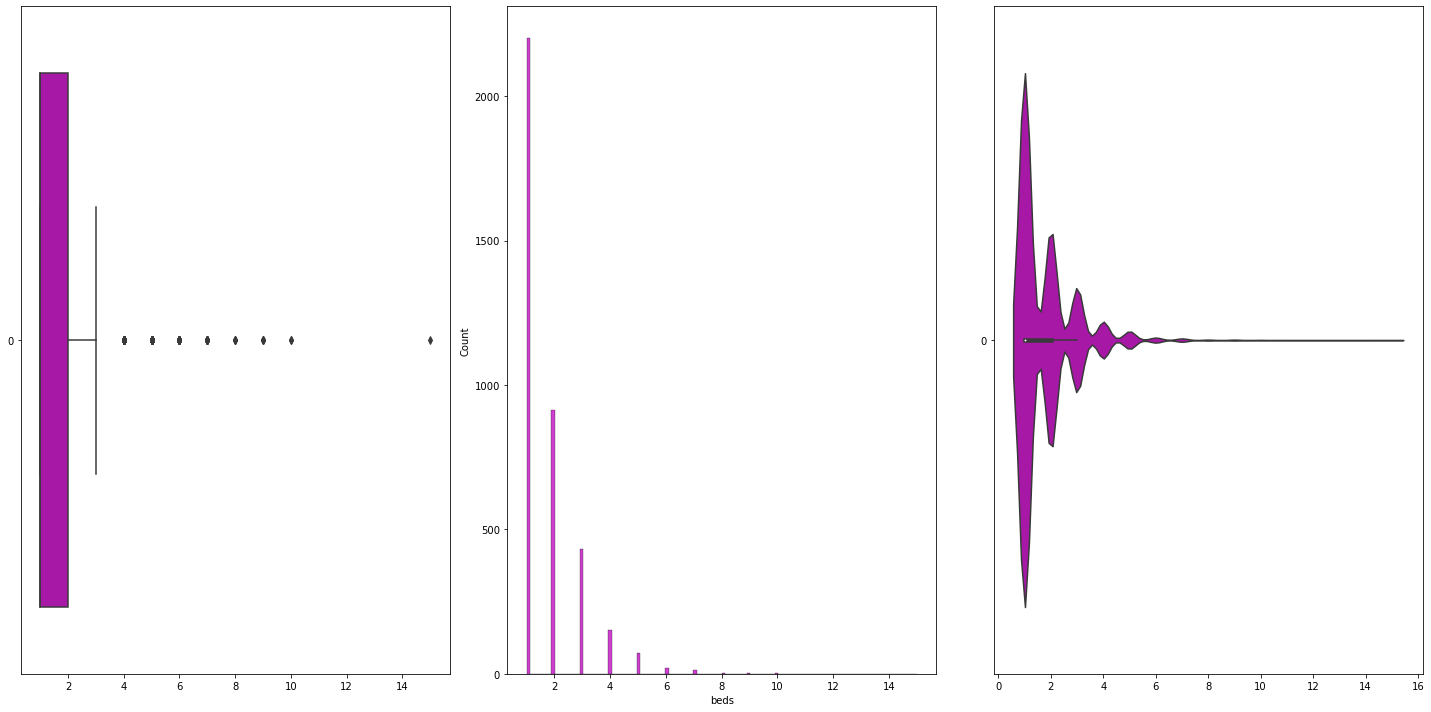

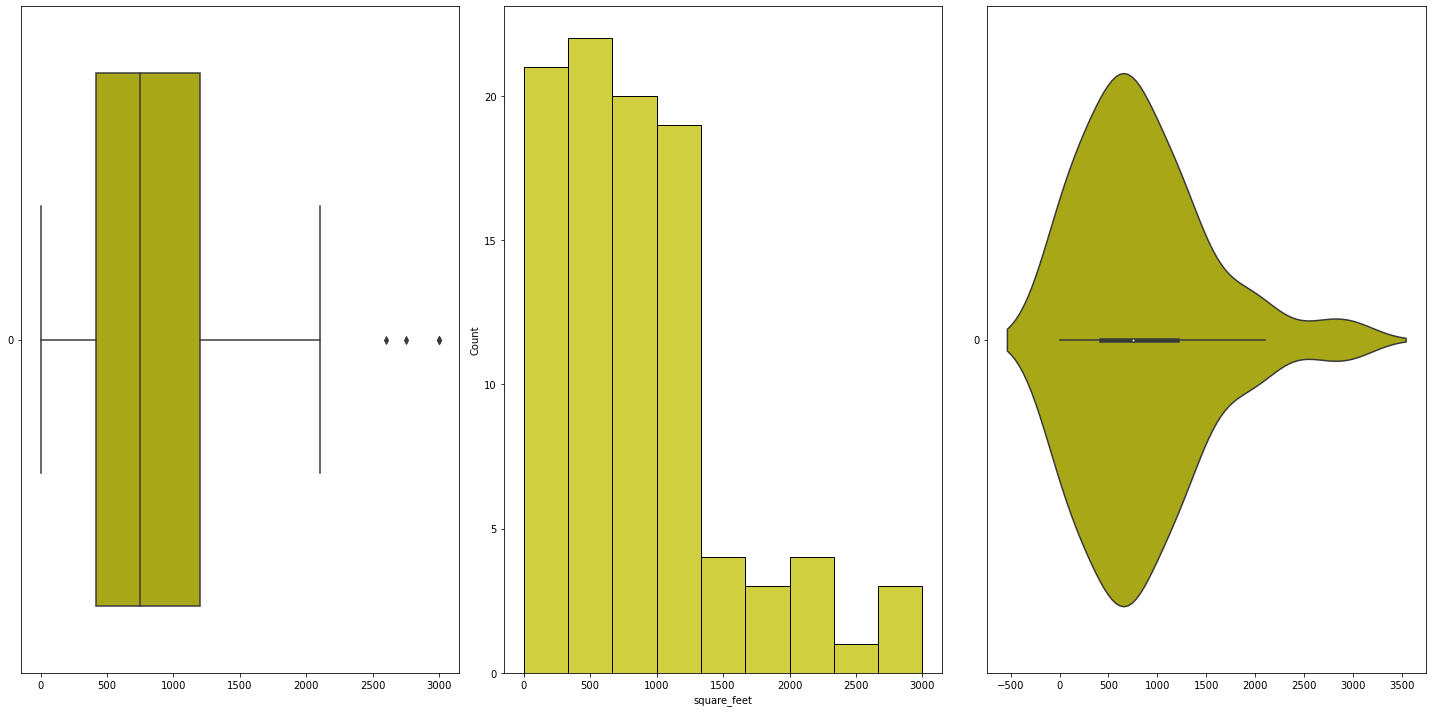

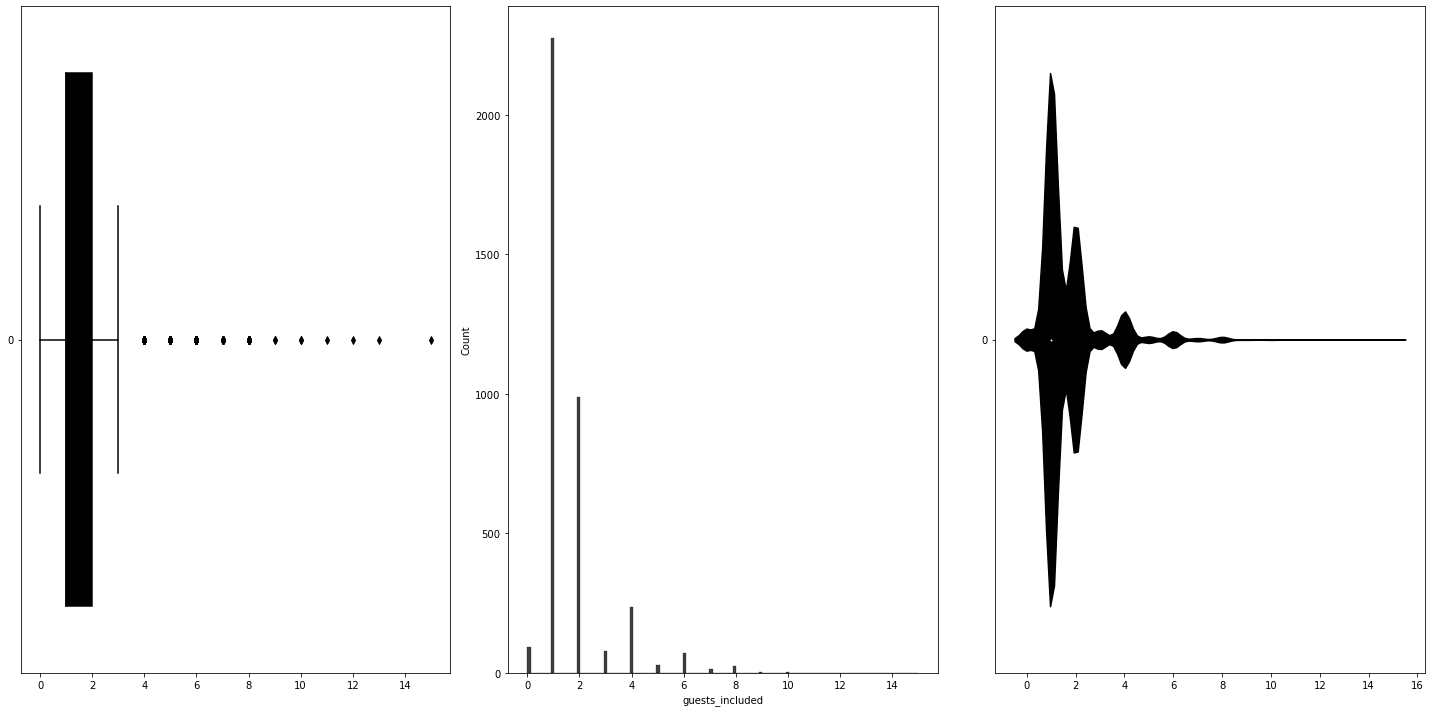

In [50]:
count = 0
colorplot = ['g','r','c','m','y','k','w']

for var in numerical_df:
    f, axes = plt.subplots(1, 3, figsize=(20, 10))
    sb.boxplot(data = numerical_df[var], orient = "h", ax = axes[0], color = colorplot[count])
    sb.histplot(data = numerical_df[var], ax = axes[1], color = colorplot[count])
    sb.violinplot(data = numerical_df[var], orient = "h", ax = axes[2], color = colorplot[count])
    count += 1
    f.tight_layout()

In [51]:
# Finding no. of outliers
Q1 = numerical_df.quantile(0.25)
Q3 = numerical_df.quantile(0.75)

rule = ((numerical_df < (Q1 - 1.5 * (Q3 - Q1))) | (numerical_df > (Q3 + 1.5 * (Q3 - Q1))))

rule.sum()

accommodates       184
bathrooms          920
bedrooms           100
beds               271
square_feet          4
guests_included    382
dtype: int64

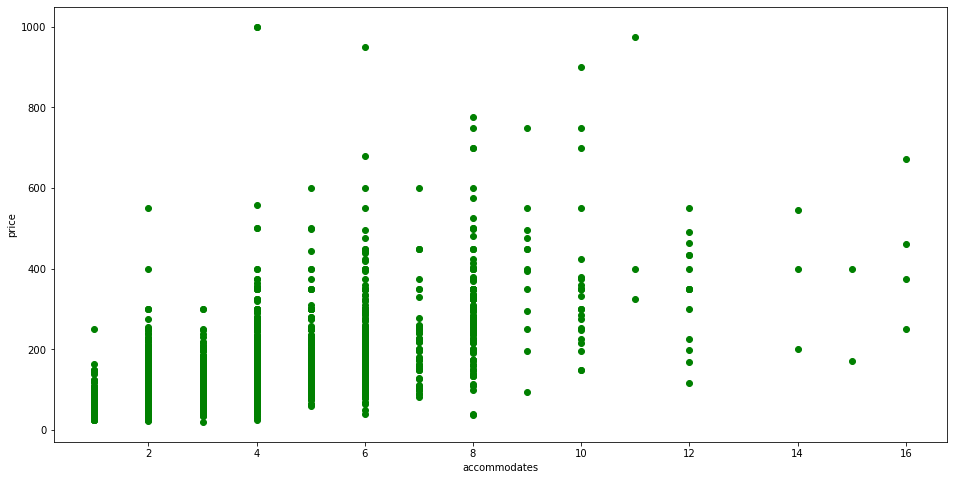

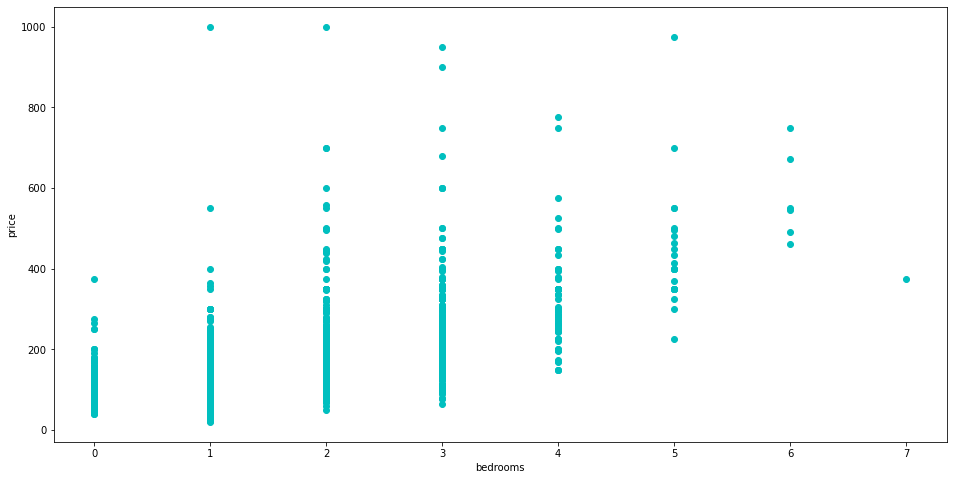

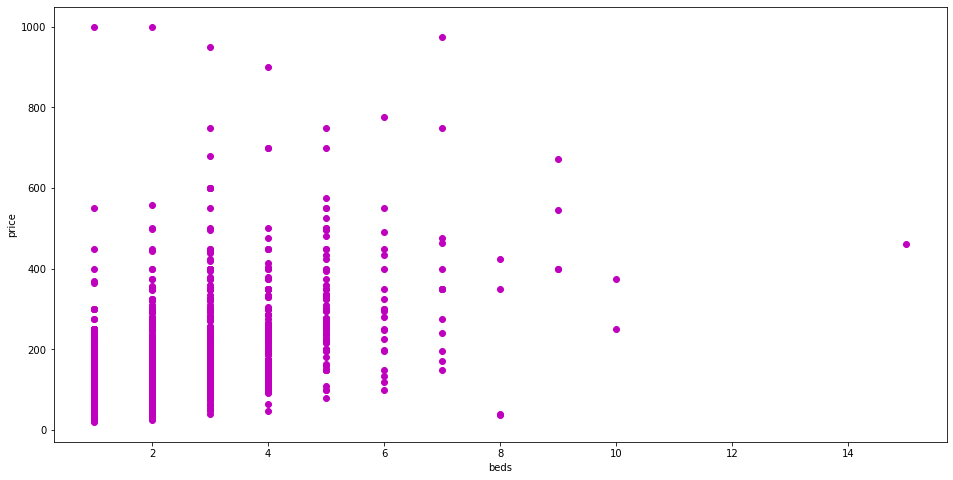

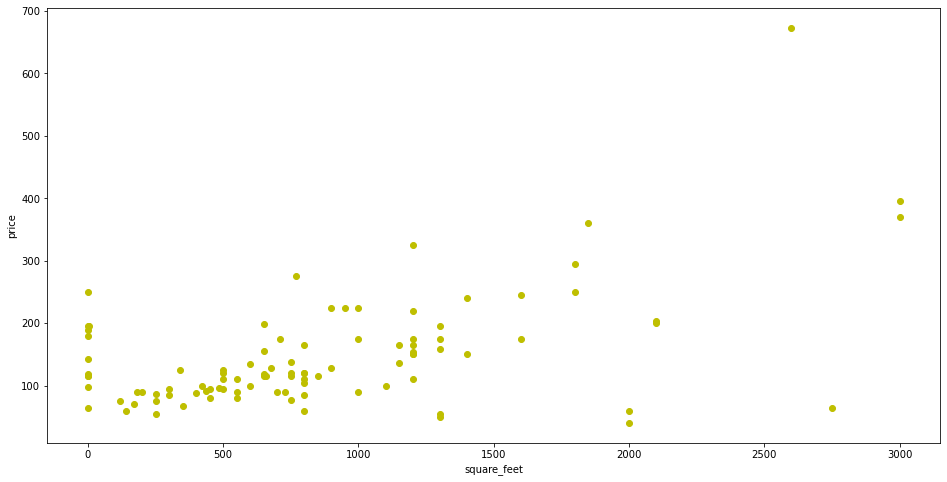

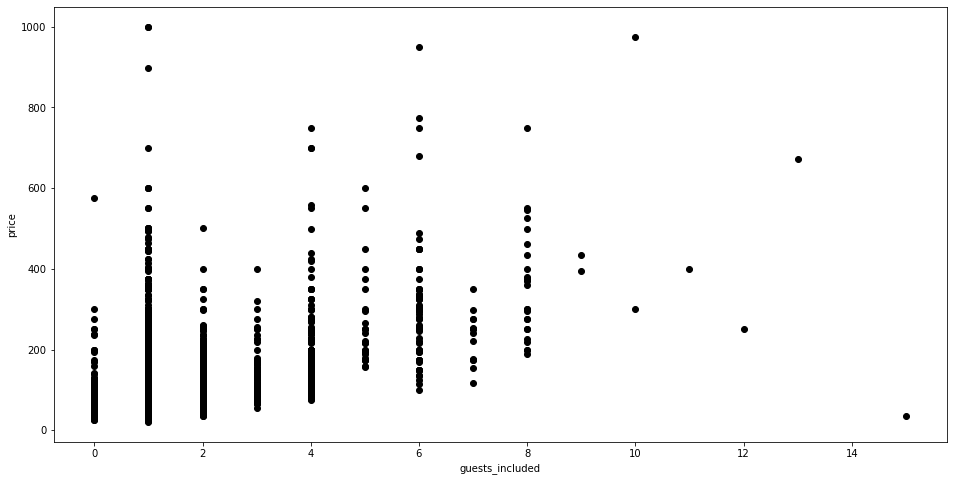

In [52]:
count = 0
for var in numerical_df:
    f = plt.figure(figsize=(16, 8))
    var1 = pd.DataFrame(numerical_df[var])
    plt.scatter(var1, price, color = colorplot[count])
    plt.xlabel(var)
    plt.ylabel("price")
    plt.show()
    count += 1
f.tight_layout()

In [53]:
numerical_df.corr()

accommodates  bathrooms  bedrooms      beds  square_feet  \
accommodates         1.000000   0.538439  0.770974  0.861119     0.439057   
bathrooms            0.538439   1.000000  0.610937  0.532838     0.381094   
bedrooms             0.770974   0.610937  1.000000  0.753167     0.448786   
beds                 0.861119   0.532838  0.753167  1.000000     0.312155   
square_feet          0.439057   0.381094  0.448786  0.312155     1.000000   
guests_included      0.532796   0.304780  0.457009  0.460512     0.471582   

                 guests_included  
accommodates            0.532796  
bathrooms               0.304780  
bedrooms                0.457009  
beds                    0.460512  
square_feet             0.471582  
guests_included         1.000000

<AxesSubplot:>

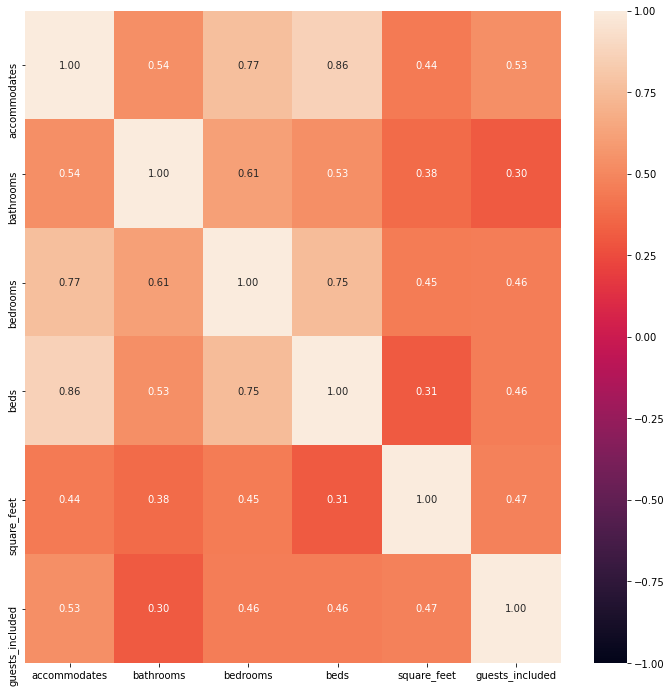

In [54]:
f = plt.figure(figsize=(12, 12))
sb.heatmap(numerical_df.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [55]:
sb.pairplot(data = numerical_df)

# 3) Final Preparation of Dataset 
- With the cleaning done for both numerical and categorical variables, we have the features that we will be keeping for our regression model.


- Now, we will be merging our variables together back into a single dataframe, and save it into a csv file to be input into the machine-learning notebook.

In [56]:
#cleaned dataframe that will be used for machine learning
new = pd.concat([categorical_df,numerical_df], axis=1)
new

id property_type        room_type neighbourhood  price  \
0       241032     Apartment  Entire home/apt    Queen Anne     85   
1       953595     Apartment  Entire home/apt    Queen Anne    150   
2      3308979         House  Entire home/apt    Queen Anne    975   
3      7421966     Apartment  Entire home/apt    Queen Anne    100   
4       278830         House  Entire home/apt    Queen Anne    450   
...        ...           ...              ...           ...    ...   
3813   8101950         House  Entire home/apt       Fremont    359   
3814   8902327     Apartment  Entire home/apt   Portage Bay     79   
3815  10267360         House  Entire home/apt           NaN     93   
3816   9604740   Condominium  Entire home/apt           NaN     99   
3817  10208623     Apartment  Entire home/apt    Queen Anne     87   

      accommodates  bathrooms  bedrooms  beds  square_feet  guests_included  
0                4        1.0       1.0   1.0          NaN                2  
1                4        1.0       1.0   1.0          NaN                1  
2               11        4.5       5.0   7.0          NaN               10  
3                3        1.0       0.0   2.0          NaN                1  
4                6        2.0       3.0   3.0          NaN                6  
...            ...        ...       ...   ...          ...              ...  
3813             6        2.0       3.0   3.0          NaN                1  
3814             4        1.0       1.0   2.0          NaN                3  
3815             2        1.0       1.0   1.0          NaN                2  
3816             2        1.0       0.0   1.0          NaN                1  
3817             3        1.5       2.0   1.0          NaN                1  

[3818 rows x 11 columns]

In [57]:
new.dtypes

id                   int64
property_type       object
room_type           object
neighbourhood       object
price                int64
accommodates         int64
bathrooms          float64
bedrooms           float64
beds               float64
square_feet        float64
guests_included      int64
dtype: object

## 3.1 Encoding Categorical Variables
- As the categorical variables are in the form of strings, the machine learning model will not be able to interpret these features correctly. 


- Hence, we will be performing encoding to convert these strings to integers representative of the categories.

In [58]:
# changed all objects using label encoder
# Import label encoder 
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_object_dtype

# label_encoder object knows how to understand word labels. 
cat_features=[x for x in new.columns if is_object_dtype(new[x]) == True]

le=LabelEncoder()

for col in cat_features:
    if col in new.columns:
        i = new.columns.get_loc(col)
        new.iloc[:,i] = new.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [59]:
new.head()

id  property_type  room_type  neighbourhood  price  accommodates  \
0   241032              0          0             59     85             4   
1   953595              0          0             59    150             4   
2  3308979              9          0             59    975            11   
3  7421966              0          0             59    100             3   
4   278830              9          0             59    450             6   

   bathrooms  bedrooms  beds  square_feet  guests_included  
0        1.0       1.0   1.0          NaN                2  
1        1.0       1.0   1.0          NaN                1  
2        4.5       5.0   7.0          NaN               10  
3        1.0       0.0   2.0          NaN                1  
4        2.0       3.0   3.0          NaN                6

In [60]:
new = new.fillna(0)
new.head()

id  property_type  room_type  neighbourhood  price  accommodates  \
0   241032              0          0             59     85             4   
1   953595              0          0             59    150             4   
2  3308979              9          0             59    975            11   
3  7421966              0          0             59    100             3   
4   278830              9          0             59    450             6   

   bathrooms  bedrooms  beds  square_feet  guests_included  
0        1.0       1.0   1.0          0.0                2  
1        1.0       1.0   1.0          0.0                1  
2        4.5       5.0   7.0          0.0               10  
3        1.0       0.0   2.0          0.0                1  
4        2.0       3.0   3.0          0.0                6

In [61]:
new.to_csv('cleaned_listing.csv')